In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import shapely
import ee
import geemap

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project='ee-corestackdev')

In [4]:
swb_layer_path = ee.FeatureCollection('projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/ponds_saraikela-kharsawan_gobindpur')

In [5]:
swb_gdf = gpd.GeoDataFrame.from_features(swb_layer_path.getInfo())

In [6]:
swb_gdf.shape

(699, 1)

In [7]:
swb_gdf

,geometry
0,"POLYGON ((86.20013 22.65664, 86.20013 22.65664..."
1,"POLYGON ((86.19875 22.65755, 86.19876 22.65755..."
2,"POLYGON ((86.19759 22.65508, 86.19759 22.65507..."
3,"POLYGON ((86.19678 22.63558, 86.19678 22.63558..."
4,"POLYGON ((86.1951 22.63293, 86.1951 22.63291, ..."
...,...
694,"POLYGON ((85.84891 22.52863, 85.84891 22.52863..."
695,"POLYGON ((85.84959 22.5276, 85.84959 22.52759,..."
696,"POLYGON ((85.84603 22.51937, 85.84604 22.51937..."
697,"POLYGON ((85.83354 22.52361, 85.83356 22.5236,..."


In [8]:
# swb_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_swb2.json'
#     )

# ponds_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells/output/17/gobindpur/gobindpur_COMBINED_GEOMETRY',
#     'gobindpur_COMBINED_GEOMETRY.shp'
#     )

# mws_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_mws.json'
#     )

# admin_boundary_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_boundary.geojson'
#     )


In [9]:
# ponds_gdf = gpd.read_file(ponds_layer_path)

# swb_gdf = gpd.read_file(swb_layer_path)

# mws_gdf = gpd.read_file(mws_layer_path)

# admin_boundary_gdf = gpd.read_file(admin_boundary_layer_path)

In [10]:
swb_layer_path = ee.FeatureCollection('projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/swb3_saraikela-kharsawan_gobindpur')

ponds_layer_path = ee.FeatureCollection('projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/ponds_saraikela-kharsawan_gobindpur')

mws_layer_path = ee.FeatureCollection('projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/filtered_mws_saraikela-kharsawan_gobindpur_uid')

admin_boundary_layer_path = ee.FeatureCollection('projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/admin_boundary_saraikela-kharsawan_gobindpur')

In [11]:
ponds_gdf = gpd.GeoDataFrame.from_features(ponds_layer_path.getInfo())

swb_gdf = gpd.GeoDataFrame.from_features(swb_layer_path.getInfo())

mws_gdf = gpd.GeoDataFrame.from_features(mws_layer_path.getInfo())

admin_boundary_gdf = gpd.GeoDataFrame.from_features(admin_boundary_layer_path.getInfo())

In [12]:
def split_multipolygon_into_individual_polygons(data_gdf):
    data_gdf = data_gdf.explode()
    return data_gdf

def clip_to_admin_boundary(data_gdf,boundary_gdf):
    data_gdf = data_gdf.sjoin(boundary_gdf[['geometry']],how = 'inner')
    data_gdf.drop(['index_right'],axis=1,inplace=True)
    return data_gdf

def change_crs(data_gdf,crs):
    data_gdf.to_crs(crs)
    return data_gdf

def generate_pond_id(data_gdf):
    data_gdf.drop(['FID'],axis=1,inplace=True,errors='ignore') #drop if the column exists
    data_gdf['pond_id'] = range(data_gdf.shape[0])
    return data_gdf

def dissolve_boundary(data_gdf):
    data_gdf = data_gdf.dissolve()
    return data_gdf

In [13]:
if (ponds_gdf.shape[0] == 1):
    ponds_gdf = split_multipolygon_into_individual_polygons(ponds_gdf)

In [14]:
ponds_gdf.columns

Index(['geometry'], dtype='object')

In [15]:
if ('pond_id' not in ponds_gdf.columns):
    ponds_gdf = generate_pond_id(ponds_gdf)

In [16]:
# ponds_gdf.head()

In [17]:
if (admin_boundary_gdf.shape[0] > 1):
    admin_boundary_gdf = dissolve_boundary(admin_boundary_gdf)

In [18]:
# admin_boundary_gdf

In [19]:
# ponds_map = admin_boundary_gdf.explore()
# ponds_gdf.explore(m=ponds_map,color='red')

In [20]:
ponds_gdf = clip_to_admin_boundary(
    data_gdf=ponds_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [21]:
ponds_gdf.shape

(415, 2)

In [22]:
swb_gdf.shape

(2306, 91)

In [23]:
# swb_map = admin_boundary_gdf.explore()
# swb_gdf.explore(m=swb_map,color='blue')

In [24]:
swb_gdf = clip_to_admin_boundary(
    data_gdf=swb_gdf,
    boundary_gdf=admin_boundary_gdf
)

In [25]:
swb_gdf.shape

(1360, 91)

In [26]:
# swb_gdf = change_crs(
#     data_gdf=swb_gdf,
#     crs='crs:7755'
# )

# ponds_gdf = change_crs(
#     data_gdf=ponds_gdf,
#     crs='crs:7755'
# )

### Create merged dataframe

1. Add standalone swb

In [27]:
intersecting_UIDs = swb_gdf.sjoin(ponds_gdf)['UID'].tolist()

In [28]:
standalone_swb_gdf = swb_gdf[~swb_gdf['UID'].isin(intersecting_UIDs)]

In [29]:
standalone_swb_gdf.shape

(1050, 91)

In [30]:
merged_gdf = standalone_swb_gdf

2. Add standalone ponds

In [31]:
intersecting_pond_ids = ponds_gdf.sjoin(swb_gdf)['pond_id'].tolist()

In [32]:
standalone_ponds_gdf = ponds_gdf[~ponds_gdf['pond_id'].isin(intersecting_pond_ids)]

In [33]:
merged_gdf = pd.concat([merged_gdf,
                        standalone_ponds_gdf])

In [34]:
merged_gdf.shape

(1167, 92)

#### Intersection scenarios

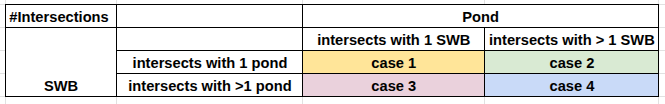

In [35]:
intersections_gdf = swb_gdf.sjoin(ponds_gdf)

In [36]:
# ponds_gdf

In [37]:
intersections_gdf.shape

(311, 93)

In [38]:
# ponds_gdf

In [39]:
swb_intersections_df = intersections_gdf.groupby(['UID'])['pond_id'].unique().reset_index()

In [40]:
pond_intersections_df = intersections_gdf.groupby(['pond_id'])['UID'].unique().reset_index()

In [41]:
merged_gdf.shape

(1167, 92)

In [42]:
single_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) == 1]

In [43]:
len(single_intersection_uids)

309

In [44]:
# single_intersection_uids

In [45]:
# pond_intersections_df

In [46]:
case_1_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) == 1):
                case_1_swb_ids.append(x)

In [47]:
len(case_1_swb_ids)

284

In [48]:
# ponds_gdf

In [49]:
case1_gdf = swb_gdf[swb_gdf['UID'].isin(case_1_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [50]:
case1_gdf.drop(['index_right'],axis=1,inplace=True)

In [51]:
for index,row in case1_gdf.iterrows():
    case1_gdf.loc[index,'geometry'] = shapely.ops.unary_union(
        [
            row['geometry'],
            ponds_gdf[ponds_gdf['pond_id'] == row['pond_id']]['geometry'].iloc[0]
        ]
    ) #new find: without the .loc it wont update the original value of the row geometries. like row['geometry] = unary_union(row['geometry'],pond['geometry']) didnt update the value


In [52]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case1_gdf
        ]
)

In [53]:
merged_gdf.shape

(1451, 92)

Case 2: Cases of ponds intersecting with more than 1 SWBs, and SWBs intersecting with only 1 pond
- In these cases we currently dont merge the boundary of the intersecting pond and swbs, but just tag the pond which intersects with an SWB, and have 1 row per SWB. 

In [54]:
single_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) == 1]
#ponds that intersect with only 1 swb

multi_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) > 1]
#ponds that intersect with only 1 swb

In [55]:
print(len(single_intersection_pond_ids))
print(len(multi_intersection_pond_ids))

286
12


In [56]:
# pond_intersections_df

In [57]:
# swb_intersections_df

In [58]:
case2_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) > 1):
                case2_swb_ids.append(x)

In [59]:
len(case2_swb_ids)

25

In [60]:
case2_gdf = swb_gdf[swb_gdf['UID'].isin(case2_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [61]:
# case2_gdf.head()

In [62]:
case2_gdf.drop(['index_right'],axis=1,inplace=True)

In [63]:
case2_gdf.shape

(25, 92)

In [64]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case2_gdf
        ]
)

In [65]:
merged_gdf.shape

(1476, 92)

In [ ]:
merged_gdf['pond_id'] = merged_gdf['pond_id'].astype('Int64')

Case 3: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with only 1 SWB  
Case 4: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with more than 1 SWB  

It makes sense to combine these cases wrt the dataframe

In [ ]:
multi_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) > 1]

In [ ]:
multi_intersection_uids

In [ ]:
case3_4_swb_ids = []
case3_4_pond_ids = []
for x in multi_intersection_uids:
    for ind,row in pond_intersections_df.iterrows():
        if (x in row['UID']):
            if (len(row['UID']) >= 1):
                # print(row['pond_id'])
                case3_4_swb_ids.append(x)
                case3_4_pond_ids.append(row['pond_id'])

In [ ]:
len(case3_4_swb_ids) #again these are intersections, not unique swb ids

In [ ]:
case3_4_gdf = swb_gdf[swb_gdf['UID'].isin(case3_4_swb_ids)].sjoin(
    ponds_gdf[ponds_gdf['pond_id'].isin(case3_4_pond_ids)],
    how='left'
)

Create merged geometry and add comma separated pond ids

In [ ]:
swb_ponds_case3_4 = case3_4_gdf.groupby(['UID'])['pond_id'].agg(set).reset_index()
swb_ponds_case3_4

In [ ]:
swb_ponds_case3_4['pond_id'] = swb_ponds_case3_4['pond_id'].apply(lambda x: list(x))

In [ ]:
swb_ponds_case3_4.dtypes

In [ ]:
case3_4_dict = swb_ponds_case3_4.set_index('UID').T.to_dict('list')

In [ ]:
# case3_4_dict

In [ ]:
case3_4_dict.values()

Learning:
* Apparently list/set or any multiple values is not a good idea to assign to a cell in pandas.  

- https://stackoverflow.com/questions/53116286/how-to-assign-an-entire-list-to-each-row-of-a-pandas-dataframe
- https://stackoverflow.com/questions/52552198/how-to-set-the-value-of-a-pandas-column-as-list/52563718#52563718

So this is a TODO for later. 
For now, I will keep it as a list. 

In [ ]:
case3_4_merged_geom = []
for swb in swb_ponds_case3_4['UID']:
    #get corresponding farmpond geometries and merge them 
    # print(swb)
    merged_geom = swb_gdf[swb_gdf['UID'] == swb]['geometry'].iloc[0]
    # print(merged_geom)
    # case3_gdf.loc[case3_gdf['UID'] == swb,'pond_id'] = np.nan
    for pond in list(swb_ponds_case3_4[swb_ponds_case3_4['UID'] == swb]['pond_id'].iloc[0]):
        merged_geom = shapely.ops.unary_union(
            [
                merged_geom,
                ponds_gdf[ponds_gdf['pond_id'] == pond]['geometry'].iloc[0]
            ])
    case3_4_merged_geom.append(merged_geom)
    case3_4_gdf.loc[case3_4_gdf['UID'] == swb,'geometry'] = merged_geom

**Not doing this**: _Keep only 1 row per SWB_
- As this is not a good pandas practice, and 
- It is creating an error in GEE front as well

In [ ]:
# case3_4_gdf = case3_4_gdf.groupby(['UID']).first().reset_index()

In [ ]:
case3_4_gdf

In [ ]:
case3_4_gdf.drop(['index_right'],axis=1,inplace=True)

In [ ]:
# case3_4_gdf.drop(['pond_id'],axis=1,inplace=True)

In [ ]:
# swb_ponds_case3_4['pond_id'] = swb_ponds_case3_4['pond_id'].astype('string')

In [ ]:
# case3_4_gdf = case3_4_gdf.merge(swb_ponds_case3_4,
#                 how='left')

In [ ]:
case3_4_gdf.dtypes

In [ ]:
case3_4_gdf.shape

In [ ]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case3_4_gdf
        ]
)

In [ ]:
merged_gdf.shape

In [ ]:
merged_gdf.dtypes

In [ ]:
# merged_gdf['pond_id'] = merged_gdf['pond_id'].astype('string')

In [ ]:
merged_gdf.reset_index(drop=True,inplace=True)

In [ ]:
merged_gdf.dtypes

In [ ]:
# !pip install geemap

In [ ]:
merged_gdf = merged_gdf.set_crs('epsg:4326')

In [ ]:
merged_gdf.shape

In [ ]:
merged_gdf['UID'].nunique()

In [ ]:
merged_fc = geemap.geopandas_to_ee(merged_gdf)

In [ ]:
task = ee.batch.Export.table.toAsset(
    **{
        "collection": merged_fc,
        "description": 'merging swb and pond layer',
        "assetId": 'projects/ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/saraikela-kharsawan_gobindpur_merged_swb_ponds',
    }
)
task.start()

* Issue here: not taking dtype of pond_id as str even though it is str
![Screenshot from 2025-05-13 17-05-18.png](<attachment:Screenshot from 2025-05-13 17-05-18.png>)
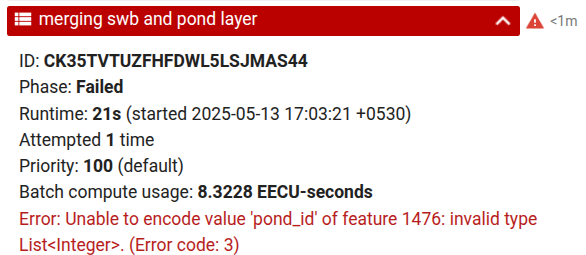

In [ ]:
# try:
#         # Export an ee.FeatureCollection as an Earth Engine asset.
#         task = ee.batch.Export.table.toAsset(
#             **{
#                 "collection": merged_fc,
#                 "description": 'merging swb and pond layer',
#                 "assetId": 'ee-corestackdev/assets/apps/mws/jharkhand/saraikela-kharsawan/gobindpur/saraikela-kharsawan_gobindpur_merged_swb_ponds',
#             }
#         )
#         task.start()
#         print("Successfully started the merge chunk", task.status())
#         return task.status()["id"]
#     except Exception as e:
#         print(f"Error occurred in running merge task: {e}")
